In [1]:
#import and fix the seed

import json
import time
import warnings

import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
from qiskit import ClassicalRegister, QuantumRegister
from qiskit import QuantumCircuit
from qiskit.circuit.library import RealAmplitudes, EfficientSU2
from qiskit.quantum_info import Statevector
from qiskit_algorithms.optimizers import COBYLA
from qiskit_algorithms.utils import algorithm_globals

from qiskit_machine_learning.circuit.library import RawFeatureVector
from qiskit_machine_learning.neural_networks import SamplerQNN

algorithm_globals.random_seed = 42    #Random generator seed 

In [2]:
#import dataset
from keras.datasets import mnist

#loading the dataset
(train_x, train_y), (test_x, test_y) = mnist.load_data()

2024-02-21 13:46:29.146241: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
#transform the data from 3D to 2D array 
nsamples, nx, ny = train_x.shape    
nsamples_1, nx_1, ny_1 = test_x.shape         
train_x = train_x.reshape((nsamples,nx*ny))   
test_x = test_x.reshape(nsamples_1,nx_1*ny_1)

In [4]:
#transform the value in the range [0,1] and divide in test/train set
from sklearn.preprocessing import MinMaxScaler

train_x = MinMaxScaler().fit_transform(train_x)
test_x = MinMaxScaler().fit_transform(test_x)

print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

(60000, 784)
(60000,)
(10000, 784)
(10000,)


In [5]:
#Select only 0's and 1's 

def filter_01(x, y):
    keep = (y == 0) | (y == 1)
    x, y = x[keep], y[keep]
    return x,y

train_x, train_y = filter_01(train_x, train_y)  #Filters the train set
test_x, test_y = filter_01(test_x, test_y)      #Filters the test set

train_x.shape

(12665, 784)

In [6]:
#Implementing PCA reduction 
from sklearn.decomposition import PCA

pca = PCA(n_components = 64)
pca1 = PCA(n_components = 64)
pca.fit(train_x)
train_x = pca.transform(train_x)
pca1.fit(test_x)
test_x = pca1.transform(test_x)

print(train_x.shape)
print(test_x.shape)

(12665, 64)
(2115, 64)


In [7]:
#Test only a fraction of the dataset

train_x = train_x[::10]
train_y = train_y[::10]
test_x = test_x[::10]
test_y = test_y[::10]

print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

(1267, 64)
(1267,)
(212, 64)
(212,)


Choose between RealAmplitudes or EfficientSU2 for the ansatz

In [8]:
#Define the ansatz and the number of repetitions
def ansatz(num_qubits):
    return RealAmplitudes(num_qubits, reps=1) 

In [9]:
#Define the ansatz and the number of repetitions
""" def ansatz(num_qubits):
    return EfficientSU2(num_qubits, reps=1) """

' def ansatz(num_qubits):\n    return EfficientSU2(num_qubits, reps=1) '

In [9]:
#define the autoencoder circuit
def auto_encoder_circuit(num_latent, num_trash):
    qr = QuantumRegister(num_latent + 2 * num_trash + 1, "q")   
    cr = ClassicalRegister(1, "c")                                                                  
    circuit = QuantumCircuit(qr, cr)    
    circuit.compose(ansatz(num_latent + num_trash), range(0, num_latent + num_trash), inplace=True) 
    circuit.barrier()   
    auxiliary_qubit = num_latent + 2 * num_trash    
    # swap test
    circuit.h(auxiliary_qubit)
    for i in range(num_trash):  
        circuit.cswap(auxiliary_qubit, num_latent + i, num_latent + num_trash + i)   

    circuit.h(auxiliary_qubit)
    circuit.measure(auxiliary_qubit, cr[0]) 
    return circuit

We have 64 features, thus we need 6 qubits, we want to compress this into 4 qubits

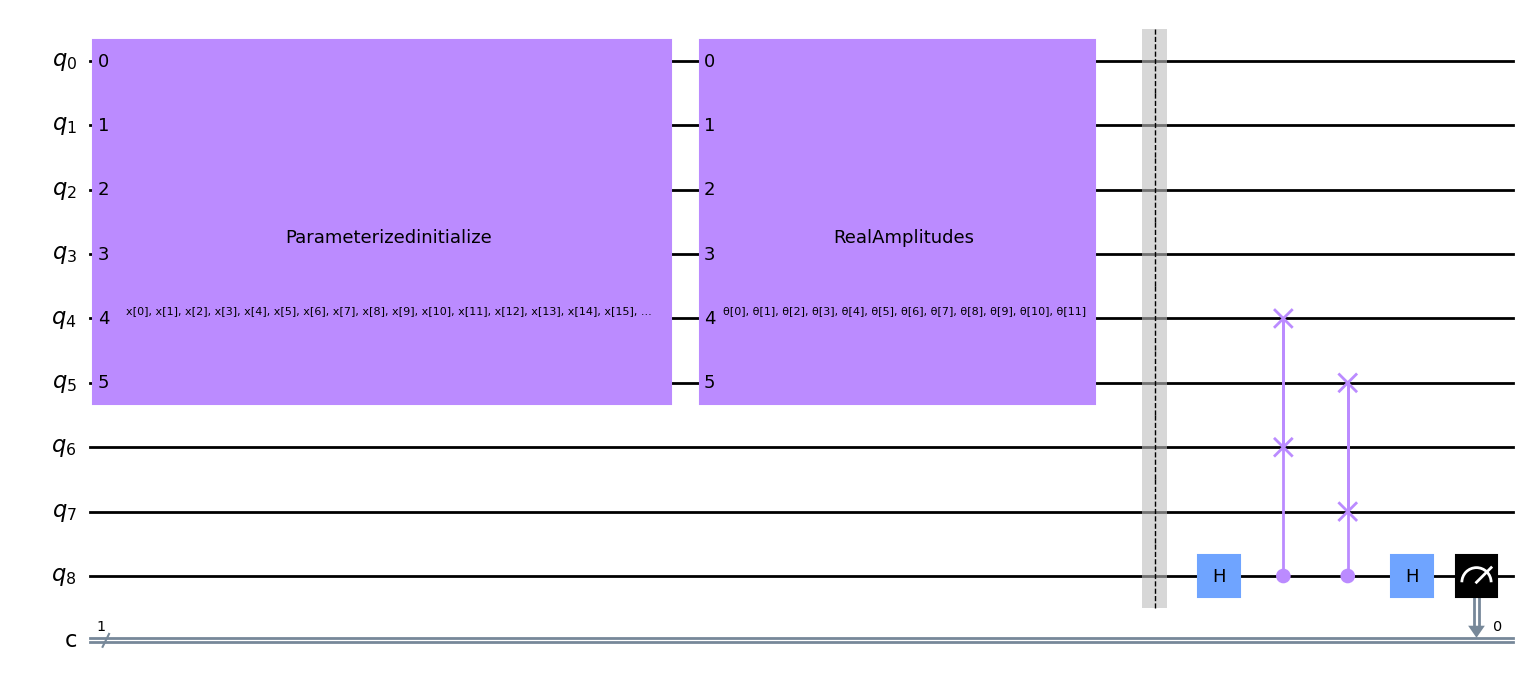

In [10]:
num_latent = 4
num_trash = 2

fm = RawFeatureVector(2 ** (num_latent + num_trash))    
ae = auto_encoder_circuit(num_latent, num_trash)

qc = QuantumCircuit(num_latent + 2 * num_trash + 1, 1)
qc = qc.compose(fm, range(num_latent + num_trash))
qc = qc.compose(ae)

qc.draw("mpl", style='clifford')

In [10]:
#interpreter function for the QNN
def parity(x):
    return f"{bin(x)}".count("1") % 2

#create the QNN
qnn = SamplerQNN(
    circuit=qc,                       #The parametrized quantum circuit that generates the samples of this network. 
    input_params=fm.parameters,       #The parameters of the circuit corresponding to the input.
    weight_params=ae.parameters,      #The parameters of the circuit corresponding to the trainable weights.
    interpret=parity,
    output_shape=2,
)

In [11]:
#cost function to minimize in the training process
def cost_func_digits(params_values):
    probabilities = qnn.forward(train_x, params_values)    
    cost = np.sum(probabilities[:, 1]) / train_x.shape[0]  

    # plotting part
    clear_output(wait=True)
    objective_func_vals.append(cost)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

    return cost

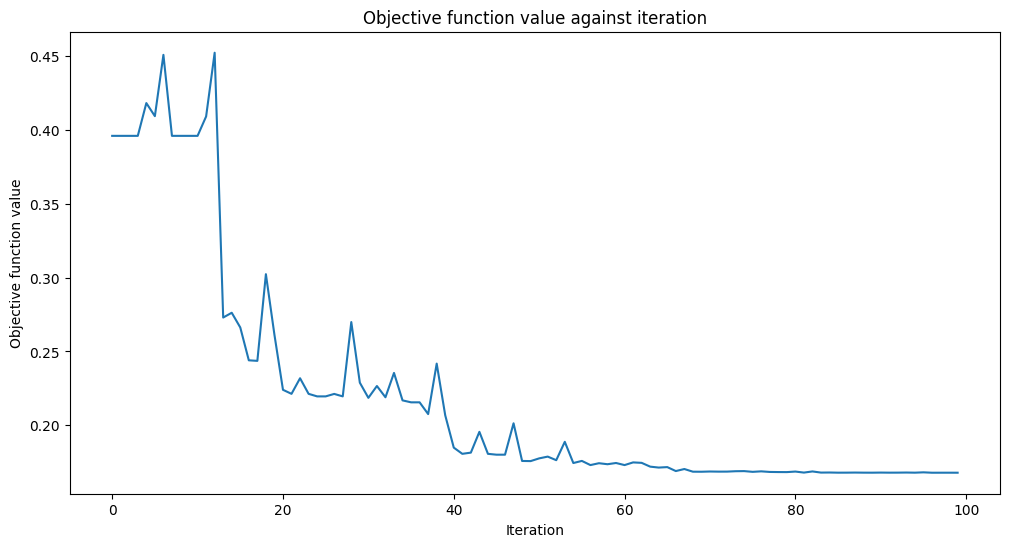

Fit in 4862.01 seconds


In [12]:
#implementing the optimization

opt = COBYLA(maxiter=100)
initial_point = algorithm_globals.random.random(ae.num_parameters)  

objective_func_vals = []

# make the plot nicer
plt.rcParams["figure.figsize"] = (12, 6)

start = time.time()
opt_result = opt.minimize(fun=cost_func_digits, x0 = initial_point)
elapsed = time.time() - start 
print(f"Fit in {elapsed:0.2f} seconds")

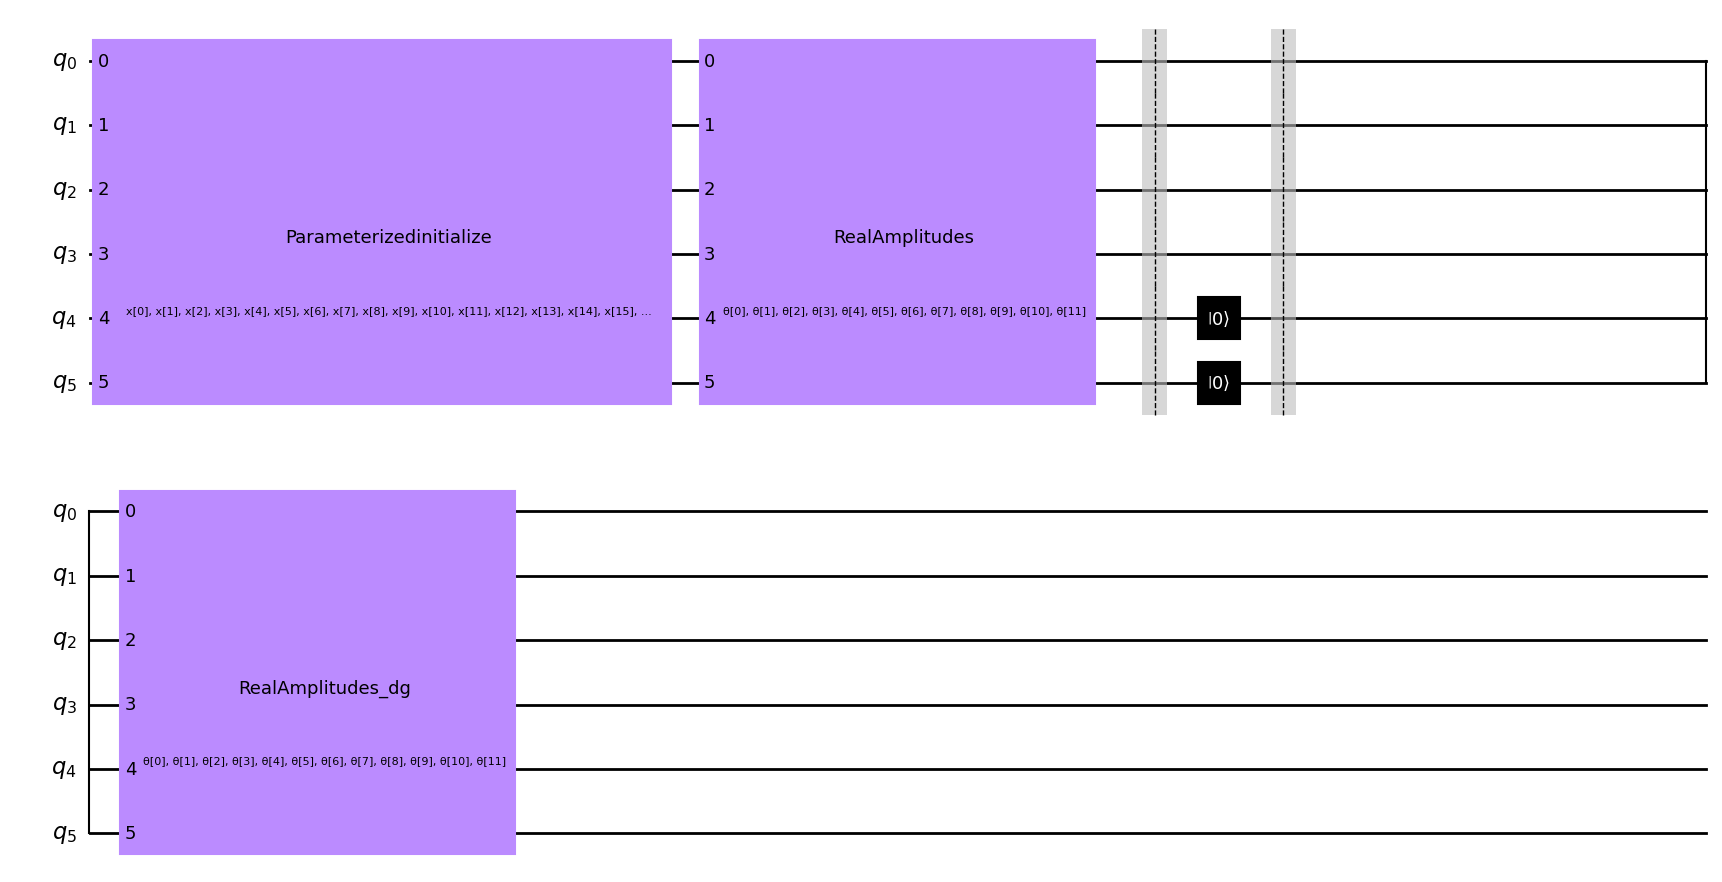

In [11]:
# Make the encoder followed by the decoder

test_qc = QuantumCircuit(num_latent + num_trash)
test_qc = test_qc.compose(fm)
ansatz_qc = ansatz(num_latent + num_trash)
test_qc = test_qc.compose(ansatz_qc)
test_qc.barrier()
test_qc.reset(4)
test_qc.reset(5)
test_qc.barrier()
test_qc = test_qc.compose(ansatz_qc.inverse())

test_qc.draw('mpl', style='clifford')

In [12]:
#import previous trained parameters
train_param = np.loadtxt("/Users/moseguerini/Desktop/QA_parameters/RA_1rep_extended.txt")
print(train_param )

[ 0.78174891  0.63116981  1.48111052 -0.02040892  0.04834463  1.14029764
  0.89518451  0.69740169 -0.96243015 -0.68459214 -0.06151947 -1.12773014]


In [14]:
# Compute the fidelity between the original state and the decoded state
""" !!! If we calculate the fidelity using saved parameters use train_param, else use opt_result.x !!! """

test_images = train_x[:]
test_labels = train_y[:]

count_fidelity = 0
count = 0
count_fidelity_test = 0
count_test = 0

for image in test_images:      
    original_qc = fm.assign_parameters(image)           
    original_sv = Statevector(original_qc).data         

    param_values = np.concatenate((image, opt_result.x))   #choose opt_result.x or train_param  
    output_qc = test_qc.assign_parameters(param_values)     
    output_sv = Statevector(output_qc).data                  

    fidelity = np.sqrt(np.dot(original_sv.conj(), output_sv) ** 2)
    count_fidelity = count_fidelity + fidelity.real
    count = count +1
    #print("Fidelity of our Output State with our Input State: ", fidelity.real)

for image, label in zip(test_x, test_y):      
    original_qc = fm.assign_parameters(image)           
    original_sv = Statevector(original_qc).data        

    param_values = np.concatenate((image, opt_result.x))    #choose opt_result.x or train_param 
    output_qc = test_qc.assign_parameters(param_values)    
    output_sv = Statevector(output_qc).data                  

    fidelity_test = np.sqrt(np.dot(original_sv.conj(), output_sv) ** 2)
    count_fidelity_test = count_fidelity_test + fidelity_test.real
    count_test = count_test +1
    #print("Fidelity of our Output State with our Input State: ", fidelity.real)

print('Mean Fidelity Train: ', count_fidelity/count)
print('Mean Fidelity Test: ', count_fidelity_test/count_test)

Mean Fidelity Train:  0.6022095700470772
Mean Fidelity Test:  0.6225611976620749


In [15]:
# Create and save the results in a txt

f = open('RA_1rep_10digits.txt', 'w')    #change name of the file                                    
print('Optimized Parameters: \n', opt_result.x, '\n' , file=f)
print('Mean Fidelity Train: ', count_fidelity/count, '\n' , file=f)
print('Mean Fidelity Test: ', count_fidelity_test/count_test, '\n' , file=f)
print(f'Training Time: {elapsed:0.2f} seconds"', '\n' , file=f)
f.close()

In [13]:
# Function to compute the fidelity between the original state and the decoded state
""" !!! If we calculate the fidelity using saved parameters use train_param, else use opt_result.x !!! """

test_images = train_x[:]
test_labels = train_y[:]


def fidelity_func(test_images, params):
    fidelity_array = []
    for image in test_images:      
        original_qc = fm.assign_parameters(image)           
        original_sv = Statevector(original_qc).data         

        param_values = np.concatenate((image, params))    
        output_qc = test_qc.assign_parameters(param_values)     
        output_sv = Statevector(output_qc).data                  

        fidelity = np.sqrt(np.dot(original_sv.conj(), output_sv) ** 2)
        fidelity_array = np.append(fidelity_array, fidelity)
        #print("Fidelity of our Output State with our Input State: ", fidelity.real)
    return fidelity_array

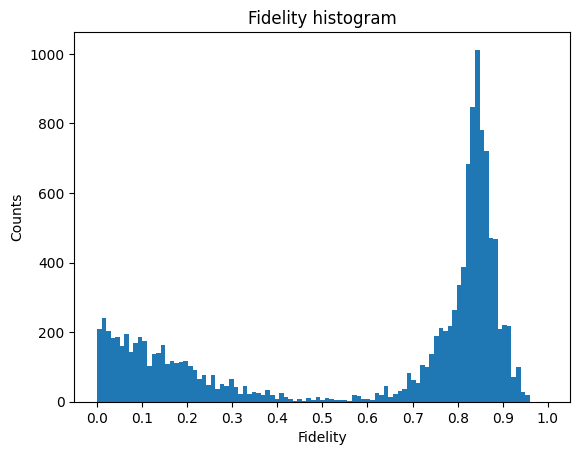

In [14]:
#Histogram of fidelity distribution
shots = 10
fidelity_hist = []

for x in range(shots):
    fid = fidelity_func(test_images, train_param)   #choose opt_result.x or train_param 
    fidelity_hist = np.append(fidelity_hist, fid)

plt.hist(fidelity_hist, bins = np.linspace(0, 1, 100)) 
plt.xticks(np.arange(0, 1.1, 0.1))
plt.title("Fidelity histogram") 
plt.xlabel("Fidelity")
plt.ylabel("Counts")
plt.show()

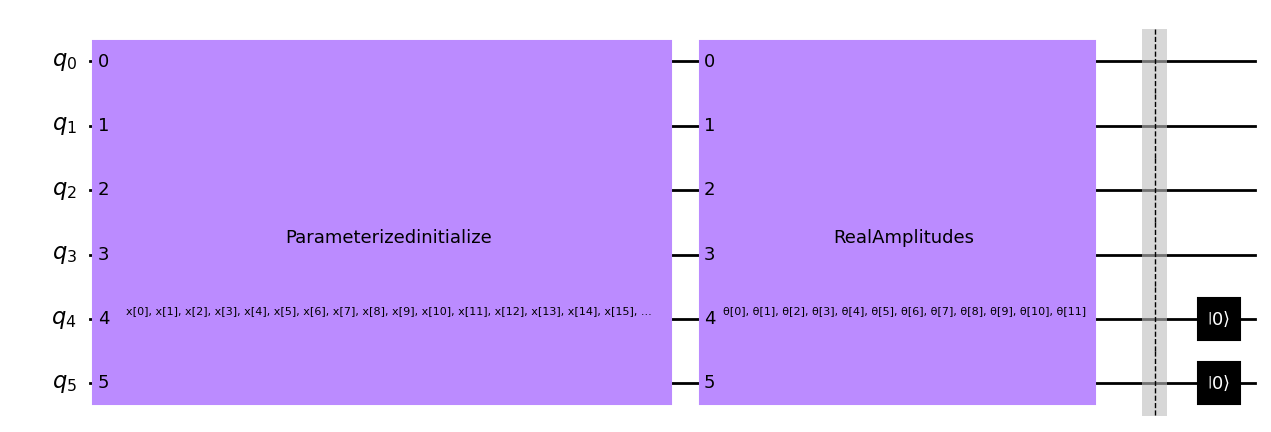

In [14]:
# Build only the encoder

enc_qc = QuantumCircuit(num_latent + num_trash)
enc_qc = enc_qc.compose(fm)
ansatz_qc = ansatz(num_latent + num_trash)
enc_qc = enc_qc.compose(ansatz_qc)
enc_qc.barrier()
enc_qc.reset(4)
enc_qc.reset(5)

enc_qc.draw('mpl', style='clifford')

In [15]:
from qiskit.quantum_info import partial_trace

def Partial_Statevector(circuit):
    """Get the statevector for the first four qubit, discarding the rest."""
    # get the full statevector of all qubits
    full_statevector = Statevector(circuit)

    # get the density matrix for the first few qubits by taking the partial trace
    partial_density_matrix = partial_trace(full_statevector, [4, 5])

    # extract the statevector out of the density matrix
    partial_statevector = np.diagonal(partial_density_matrix)

    return partial_statevector

In [16]:
# Encode the data using the trained circuit
"""As before choose between train_param or opt_result.x"""
train_x_enc = np.array([])
test_x_enc = np.array([])

for image in train_x:      

    param_values = np.concatenate((image, train_param))     
    output_qc = enc_qc.bind_parameters(param_values)       
    output_sv = Partial_Statevector(output_qc).data          
    output_sv = np.abs(output_sv) **2              
    train_x_enc = np.append(train_x_enc, output_sv)

for image in test_x:     

    param_values = np.concatenate((image, train_param))    
    output_qc = enc_qc.bind_parameters(param_values)     
    output_sv = Partial_Statevector(output_qc).data
    output_sv = np.abs(output_sv) **2                
    test_x_enc = np.append(test_x_enc, output_sv)

train_x_enc = train_x_enc.reshape(train_x.shape[0], 2**num_latent)
test_x_enc = test_x_enc.reshape(test_x.shape[0], 2**num_latent)

print(train_x_enc.shape)
print(test_x_enc.shape)

/var/folders/sg/w5ry03152vx0hhr3jsd2cdy80000gn/T/ipykernel_9441/3848788157.py:9: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.bind_parameters()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use assign_parameters() instead
  output_qc = enc_qc.bind_parameters(param_values)      #assign param_values to the test circuit 32 to RawFeatureVector and 30 to RealAmplitudes
/var/folders/sg/w5ry03152vx0hhr3jsd2cdy80000gn/T/ipykernel_9441/3848788157.py:17: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.bind_parameters()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use assign_parameters() instead
  output_qc = enc_qc.bind_parameters(param_values)     #assign param_values to the test circuit 32 to RawFeatureVector and 30 to RealAmplitudes


(1267, 16)
(212, 16)


In [19]:
#classifier for encoded images
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

model = RandomForestClassifier(n_estimators = 1000)
model.fit(train_x_enc, train_y)
ypred = model.predict(test_x_enc)

print(metrics.classification_report(ypred, test_y))

              precision    recall  f1-score   support

           0       0.91      0.66      0.77       130
           1       0.63      0.90      0.74        82

    accuracy                           0.75       212
   macro avg       0.77      0.78      0.75       212
weighted avg       0.80      0.75      0.76       212



Text(0.5, 1.0, 'Confusion matrix Random Forest Classifier')

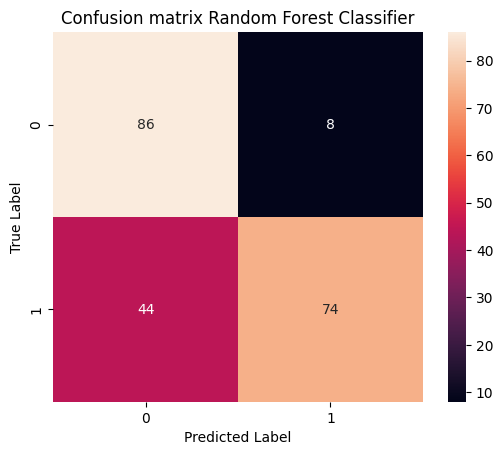

In [20]:
#plot confusion matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix 

mat = confusion_matrix(test_y, ypred)
sns.heatmap(mat, square = True, annot = True, fmt='d', cbar=True)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion matrix Random Forest Classifier')